In [1]:
%matplotlib inline


In [2]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from lightkurve import TessLightCurveFile
from astropy.coordinates import SkyCoord
import astropy.units as u
import lightkurve

import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt


In [3]:
target = 'l 98-59'
tpf = lightkurve.search_targetpixelfile(target).download()

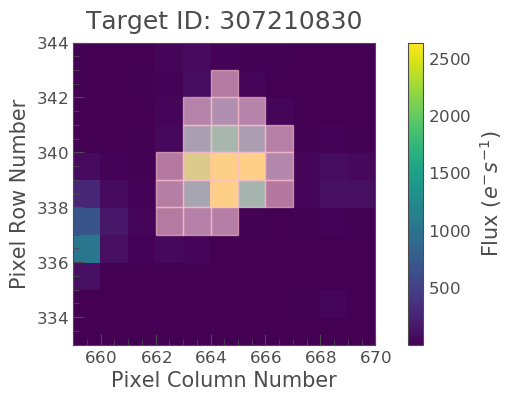

In [4]:
texp = tpf.hdu[1].header['FRAMETIM'] * tpf.hdu[1].header["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0
time = tpf.time
flux = tpf.flux

pix_mask = tpf.create_threshold_mask(threshold=3)
tpf.plot(aperture_mask=pix_mask, )


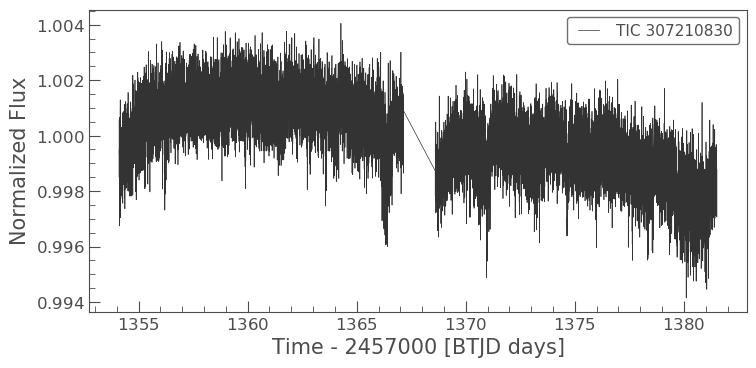

In [5]:
lc = tpf.extract_aperture_photometry(aperture_mask=pix_mask, )
lc = lc.normalize()
lc.plot()
lc.flux = (lc.flux - 1.0) * 1e3

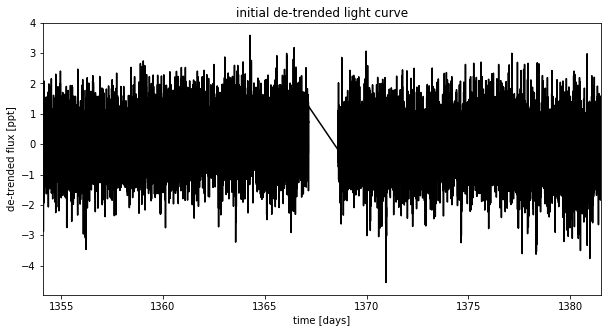

In [6]:
# Build the first order PLD basis
X_pld = np.reshape(flux[:, pix_mask], (len(flux), -1))
X_pld = X_pld / np.sum(flux[:, pix_mask], axis=-1)[:, None]

# Build the second order PLD basis and run PCA to reduce the number of dimensions
X2_pld = np.reshape(X_pld[:, None, :] * X_pld[:, :, None], (len(flux), -1))
U, _, _ = np.linalg.svd(X2_pld, full_matrices=False)
X2_pld = U[:, :X_pld.shape[1]]

# Construct the design matrix and fit for the PLD model
X_pld = np.concatenate((np.ones((len(flux), 1)), X_pld, X2_pld), axis=-1)
XTX = np.dot(X_pld.T, X_pld)
w_pld = np.linalg.solve(XTX, np.dot(X_pld.T, lc.flux))
pld_flux = np.dot(X_pld, w_pld)

# Plot the de-trended light curve
plt.figure(figsize=(10, 5))
plt.plot(time, lc.flux-pld_flux, "k")
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("initial de-trended light curve")
plt.xlim(time.min(), time.max());

In [14]:
from astropy.stats import BoxLeastSquares

period_grid = np.exp(np.linspace(np.log(0.1), np.log(15), 50000))
duration = 0.03

bls_periods = np.zeros([3])
bls_t0s = np.zeros([3])
bls_depths = np.zeros([3])

# planet 1
bls = BoxLeastSquares(lc.time, lc.flux - pld_flux)
bls_power = bls.power(period_grid, duration, oversample=20)

bls_power0 = bls_power

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
transit_mask = bls.transit_mask(lc.time, bls_period, 3*duration, bls_t0)

bls_periods[0] = bls_period
bls_t0s[0] = bls_t0
bls_depths[0] = bls_depth

# planet 2
bls = BoxLeastSquares(lc.time[~transit_mask], lc.flux[~transit_mask] - pld_flux[~transit_mask])
bls_power = bls.power(period_grid, duration, oversample=20)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
transit_mask = np.logical_or((transit_mask), (bls.transit_mask(lc.time, bls_period, 3*duration, bls_t0)))

bls_periods[1] = bls_period
bls_t0s[1] = bls_t0
bls_depths[1] = bls_depth

# planet 3
bls = BoxLeastSquares(lc.time[~transit_mask], lc.flux[~transit_mask] - pld_flux[~transit_mask])
bls_power = bls.power(period_grid, duration, oversample=20)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
transit_mask = np.logical_or((transit_mask), (bls.transit_mask(lc.time, bls_period, 3*duration, bls_t0)))

bls_periods[2] = bls_period
bls_t0s[2] = bls_t0
bls_depths[2] = bls_depth

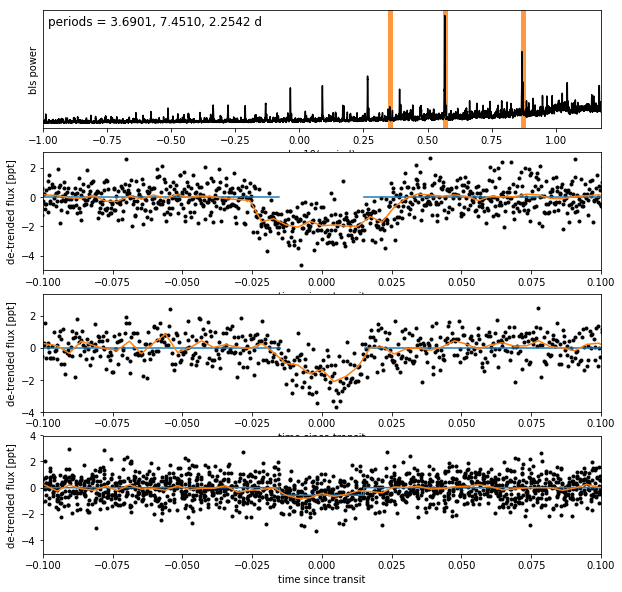

In [15]:
fig, axes = plt.subplots(4, 1, figsize=(10, 10))

# Plot the periodogram
ax = axes[0]
ax.axvline(np.log10(bls_periods[0]), color="C1", lw=5, alpha=0.8)
ax.axvline(np.log10(bls_periods[1]), color="C1", lw=5, alpha=0.8)
ax.axvline(np.log10(bls_periods[2]), color="C1", lw=5, alpha=0.8)
ax.plot(np.log10(bls_power0.period), bls_power0.power, "k")
ax.annotate("periods = {0:.4f}, {1:.4f}, {2:.4f} d".format(*bls_periods),
            (0, 1), xycoords="axes fraction",
            xytext=(5, -5), textcoords="offset points",
            va="top", ha="left", fontsize=12)
ax.set_ylabel("bls power")
ax.set_yticks([])
ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
ax.set_xlabel("log10(period)")

# Plot the folded transits
for i in range(3):
    ax = axes[i+1]
    x_fold = (lc.time - bls_t0s[i] + 0.5*bls_periods[i])%bls_periods[i] - 0.5*bls_periods[i]
    m = np.abs(x_fold) < 0.4
    ax.plot(x_fold[m], lc.flux[m] - pld_flux[m], ".k")
    inds = np.argsort(x_fold[m])
    ax.plot(x_fold[m][inds], bls.model(lc.time[m], bls_periods[i], duration, bls_t0s[i])[inds])

    # Overplot the phase binned light curve
    bins = np.linspace(-0.11, 0.11, 52)
    denom, _ = np.histogram(x_fold, bins)
    num, _ = np.histogram(x_fold, bins, weights=lc.flux - pld_flux)
    denom[num == 0] = 1.0
    ax.plot(0.5*(bins[1:] + bins[:-1]), num / denom, color="C1")

    ax.set_xlim(-0.1, 0.1)
    ax.set_ylabel("de-trended flux [ppt]")
    ax.set_xlabel("time since transit");

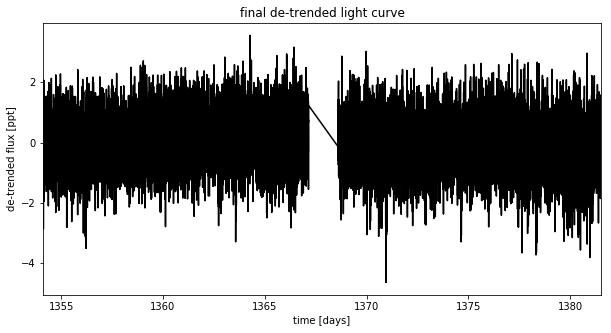

In [16]:
m = ~transit_mask
XTX = np.dot(X_pld[m].T, X_pld[m])
w_pld = np.linalg.solve(XTX, np.dot(X_pld[m].T, lc.flux[m]))
pld_flux = np.dot(X_pld, w_pld)

x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray(lc.flux-pld_flux, dtype=np.float64)

plt.figure(figsize=(10, 5))
plt.plot(lc.time, y, "k")
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("final de-trended light curve")
plt.xlim(lc.time.min(), lc.time.max());

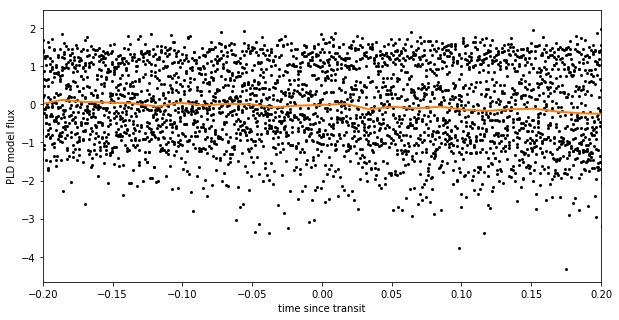

In [17]:
plt.figure(figsize=(10, 5))

x_fold = (x - bls_t0 + 0.5*bls_period) % bls_period - 0.5*bls_period
m = np.abs(x_fold) < 0.3
plt.plot(x_fold[m], pld_flux[m], ".k", ms=4)

bins = np.linspace(-0.5, 0.5, 60)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=pld_flux)
denom[num == 0] = 1.0
plt.plot(0.5*(bins[1:] + bins[:-1]), num / denom, color="C1", lw=2)
plt.xlim(-0.2, 0.2)
plt.xlabel("time since transit")
plt.ylabel("PLD model flux");

In [57]:

def build_model(mask=None, start=None, savelc=False):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        u_star = xo.distributions.QuadLimbDark("u_star",
                                              testval=np.array([0.3, 0.2]))
        
        # Stellar parameters from Kostov et al (2018)
        R_star_kostov = 0.291, 0.025
#         M_star_kostov = 0.32, 0.025
        Rho_star_kostov = 18.0
#         m_star = pm.Normal("m_star", mu=M_star_kostov[0], sd=M_star_kostov[1])
        r_star = pm.Normal("r_star", mu=R_star_kostov[0], sd=R_star_kostov[1])

        logrho_star = pm.Normal("logrho_star", mu=np.log(Rho_star_kostov), sd=0.3)
        rho_star = pm.Deterministic("rho_star", tt.exp(logrho_star))

        # Prior to require physical parameters
#         pm.Potential("m_star_prior", tt.switch(m_star > 0, 0, -np.inf))
        pm.Potential("r_star_prior", tt.switch(r_star > 0, 0, -np.inf))
        pm.Potential("rho_star_prior", tt.switch(rho_star > 0, 0, -np.inf))


        # Orbital parameters for the planets
        logP = pm.Normal("logP", mu=np.log(bls_periods), sd=0.1, shape=3)
        t0 = pm.Normal("t0", mu=bls_t0s, sd=0.1, shape=3)
        logror = pm.Normal("logror", mu=np.log(np.sqrt(1e-3)*np.sqrt(bls_depths)),
                           sd=1, shape=3)
        ror = pm.Deterministic("r", tt.exp(logror))
        b_param = pm.Uniform("b_param", lower=0, upper=1, shape=3, testval=[0.1,0.9,0.1])
        b = pm.Deterministic("b", b_param * (1 + ror))
#         ror, b = xo.distributions.get_joint_radius_impact(
#             min_radius=0.01, max_radius=0.3,
#             testval_r=np.sqrt(1e-3)*np.sqrt(bls_depths),
#             testval_b=[0.2,0.9,0.2])
        
#         sqesinw = pm.Uniform("sqesinw", lower=-0.99, upper=0.99, shape=3,
#                              testval=[0.01, 0.01, 0.01])
#         sqecosw = pm.Uniform("sqecosw", lower=-0.99, upper=0.99, shape=3,
#                              testval=[0.01, 0.01, 0.01])
        
#         ecc = pm.Deterministic("ecc",  (sqesinw * sqesinw) +  (sqecosw * sqecosw))
#         omega = pm.Deterministic("omega",  tt.arctan(sqesinw / sqecosw))
        
        ecc = pm.Bound(pm.Beta, lower=0.0, upper=0.99)("ecc", alpha=0.867, beta=3.03,
                                                       testval=[0.01,0.01,0.01], shape=3)
        omega = xo.distributions.Angle("omega", shape=3)

        
        # Log-uniform prior on ror
#         pm.Potential("ror_prior", -tt.log(ror))
        pm.Potential("ror_prior_lo", tt.switch(tt.all(0.01 < ror), 0.0, -np.inf))
        pm.Potential("ror_prior_hi", tt.switch(tt.all(ror < 0.3), 0.0, -np.inf))

        # Transit jitter & GP parameters
        logs2 = pm.Normal("logs2", mu=np.log(np.var(y[mask])), sd=10)
        logS0 = pm.Normal("logS0", mu=np.log(np.var(y[mask])), sd=10)
        logw0 = pm.Normal("logw0", mu=np.log(2*np.pi/10), sd=10)

        # Tracking planet parameters
        period = pm.Deterministic("period", tt.exp(logP))
        r_pl = pm.Deterministic("r_pl", (r_star * ror))
        r_ple = pm.Deterministic("r_ple", (r_star * ror / 0.009155))

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star, #m_star=m_star,
            period=period, t0=t0, b=b,
            ecc=ecc, omega=omega,
            rho_star=rho_star)
        
        a = pm.Deterministic("a", orbit.a)
        pm.Potential("ecc_prior", tt.switch((ecc < 1 - (1/a)), 0, -np.inf))
#         pm.Deterministic("rho_star", orbit.rho_star)
#         pm.Potential("ecc_prior2", tt.switch(ecc > 0, 0, -np.inf))

        # Compute the model light curve using starry
        light_curves = xo.StarryLightCurve(u_star, r_star=r_star).get_light_curve(
            orbit=orbit, r=r_pl, t=x[mask], texp=texp)*1e3
        light_curve = pm.math.sum(light_curves, axis=-1)
        
        if savelc:
            pm.Deterministic("light_curve", light_curve)
            model.light_curves = light_curves

        # GP model for the light curve
        kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
        gp = xo.gp.GP(kernel, x[mask], tt.exp(logs2) + tt.zeros(mask.sum()), J=2)
        pm.Potential("transit_obs", gp.log_likelihood(y[mask] - light_curve - mean))
        pm.Deterministic("gp_pred", gp.predict())

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = pm.find_MAP(start=start, vars=[logs2, logS0, logw0])
        map_soln = pm.find_MAP(start=map_soln, vars=[model.logror, model.b_param])
        map_soln = pm.find_MAP(start=map_soln)

    return model, map_soln

model0, map_soln0 = build_model(savelc=True)

/home/tom/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
logp = -22,649, ||grad|| = 279.02: 100%|██████████| 27/27 [00:00<00:00, 47.50it/s]  
logp = -22,611, ||grad|| = 0.91867: 100%|██████████| 48/48 [00:00<00:00, 52.10it/s]  
logp = -22,609, ||grad|| = 437.98: 100%|██████████| 22/22 [00:00<00:00, 42.35it/s]      


/home/tom/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


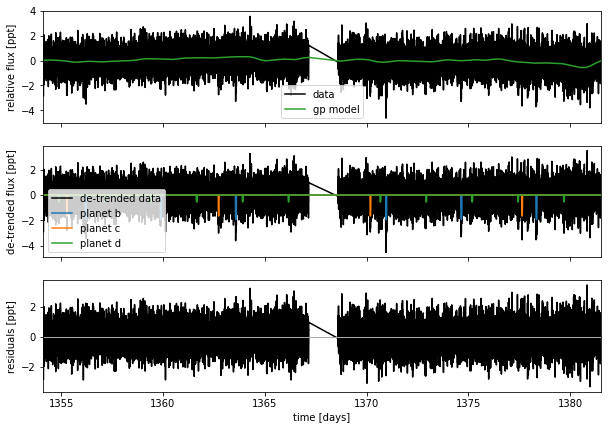

In [58]:
def plot_light_curve(model, soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = soln["gp_pred"] + soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    light_curves = xo.utils.eval_in_model(model.light_curves, soln, model=model)
    for i, l in enumerate(["b", "c", 'd']):
        mod = light_curves[:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(l))
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + np.sum(light_curves, axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")
    
    return fig
    
plot_light_curve(model0, map_soln0);

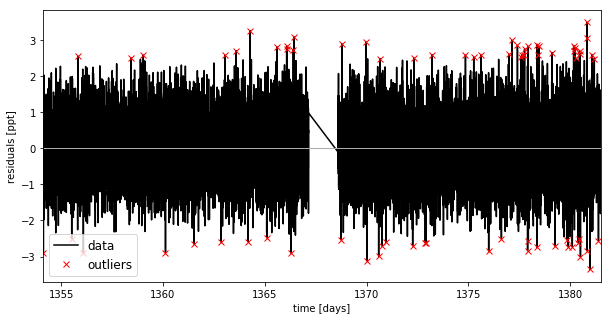

In [59]:
mod = map_soln0["gp_pred"] + map_soln0["mean"] + map_soln0["light_curve"]
resid = y - mod
rms = np.sqrt(np.median(resid**2))
mask = np.abs(resid) < 4.5 * rms

plt.figure(figsize=(10, 5))
plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=3)
plt.xlim(x.min(), x.max());


In [60]:
map_soln0.pop('light_curve')
model, map_soln = build_model(mask, map_soln0)
# # plot_light_curve(map_soln, mask);

/home/tom/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
logp = -22,148, ||grad|| = 0.18859: 100%|██████████| 12/12 [00:00<00:00, 52.62it/s]  
logp = -22,148, ||grad|| = 3.2039: 100%|██████████| 29/29 [00:00<00:00, 54.84it/s]  
logp = -22,148, ||grad|| = 2.8857e+05: 100%|██████████| 16/16 [00:00<00:00, 45.67it/s]  


In [61]:
# np.random.seed(42)
sampler = xo.PyMC3Sampler(window=200, start=500, finish=500)
with model:
    burnin = sampler.tune(tune=3000, start=map_soln, step_kwargs=dict(target_accept=0.9))

/home/tom/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Sampling 4 chains: 100%|██████████| 7608/7608 [9:45:29<00:00, 14.50s/draws]   


In [62]:
with model:
    trace = sampler.sample(draws=3000,)

/home/tom/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Sampling 4 chains: 100%|██████████| 14000/14000 [6:51:26<00:00,  4.33s/draws]  
There were 80 divergences after tuning. Increase `target_accept` or reparameterize.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
There were 96 divergences after tuning. Increase `target_accept` or reparameterize.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.


In [63]:
pm.summary(trace, varnames=["logw0", "logS0", "logs2", "omega",  "r_pl", "a",
                            "ecc", "b", "t0", "period", "r_star", "rho_star", "u_star", "mean"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
logw0,0.517974,0.198531,0.002302,0.134538,0.916356,7638.520692,1.000519
logS0,-3.463909,0.500144,0.006444,-4.401536,-2.510758,6626.200261,1.000760
logs2,-0.415862,0.010385,0.000096,-0.434930,-0.394510,10763.016404,1.000186
omega__0,-0.722800,1.703393,0.024244,-3.141370,2.743890,4986.825147,1.000051
omega__1,0.423478,1.775906,0.036420,-2.906037,3.055661,2199.014167,1.001571
omega__2,-0.005380,1.846492,0.022953,-3.114020,2.912503,5985.468696,1.000113
r_pl__0,0.011873,0.001115,0.000013,0.009767,0.014104,7802.937910,0.999939
r_pl__1,0.012514,0.001525,0.000043,0.009558,0.015488,1117.496159,1.001032
r_pl__2,0.006571,0.000730,0.000010,0.005179,0.008023,5839.333729,1.000315
a__0,6.746115,0.780650,0.009913,5.273812,8.314260,6673.302484,0.999877


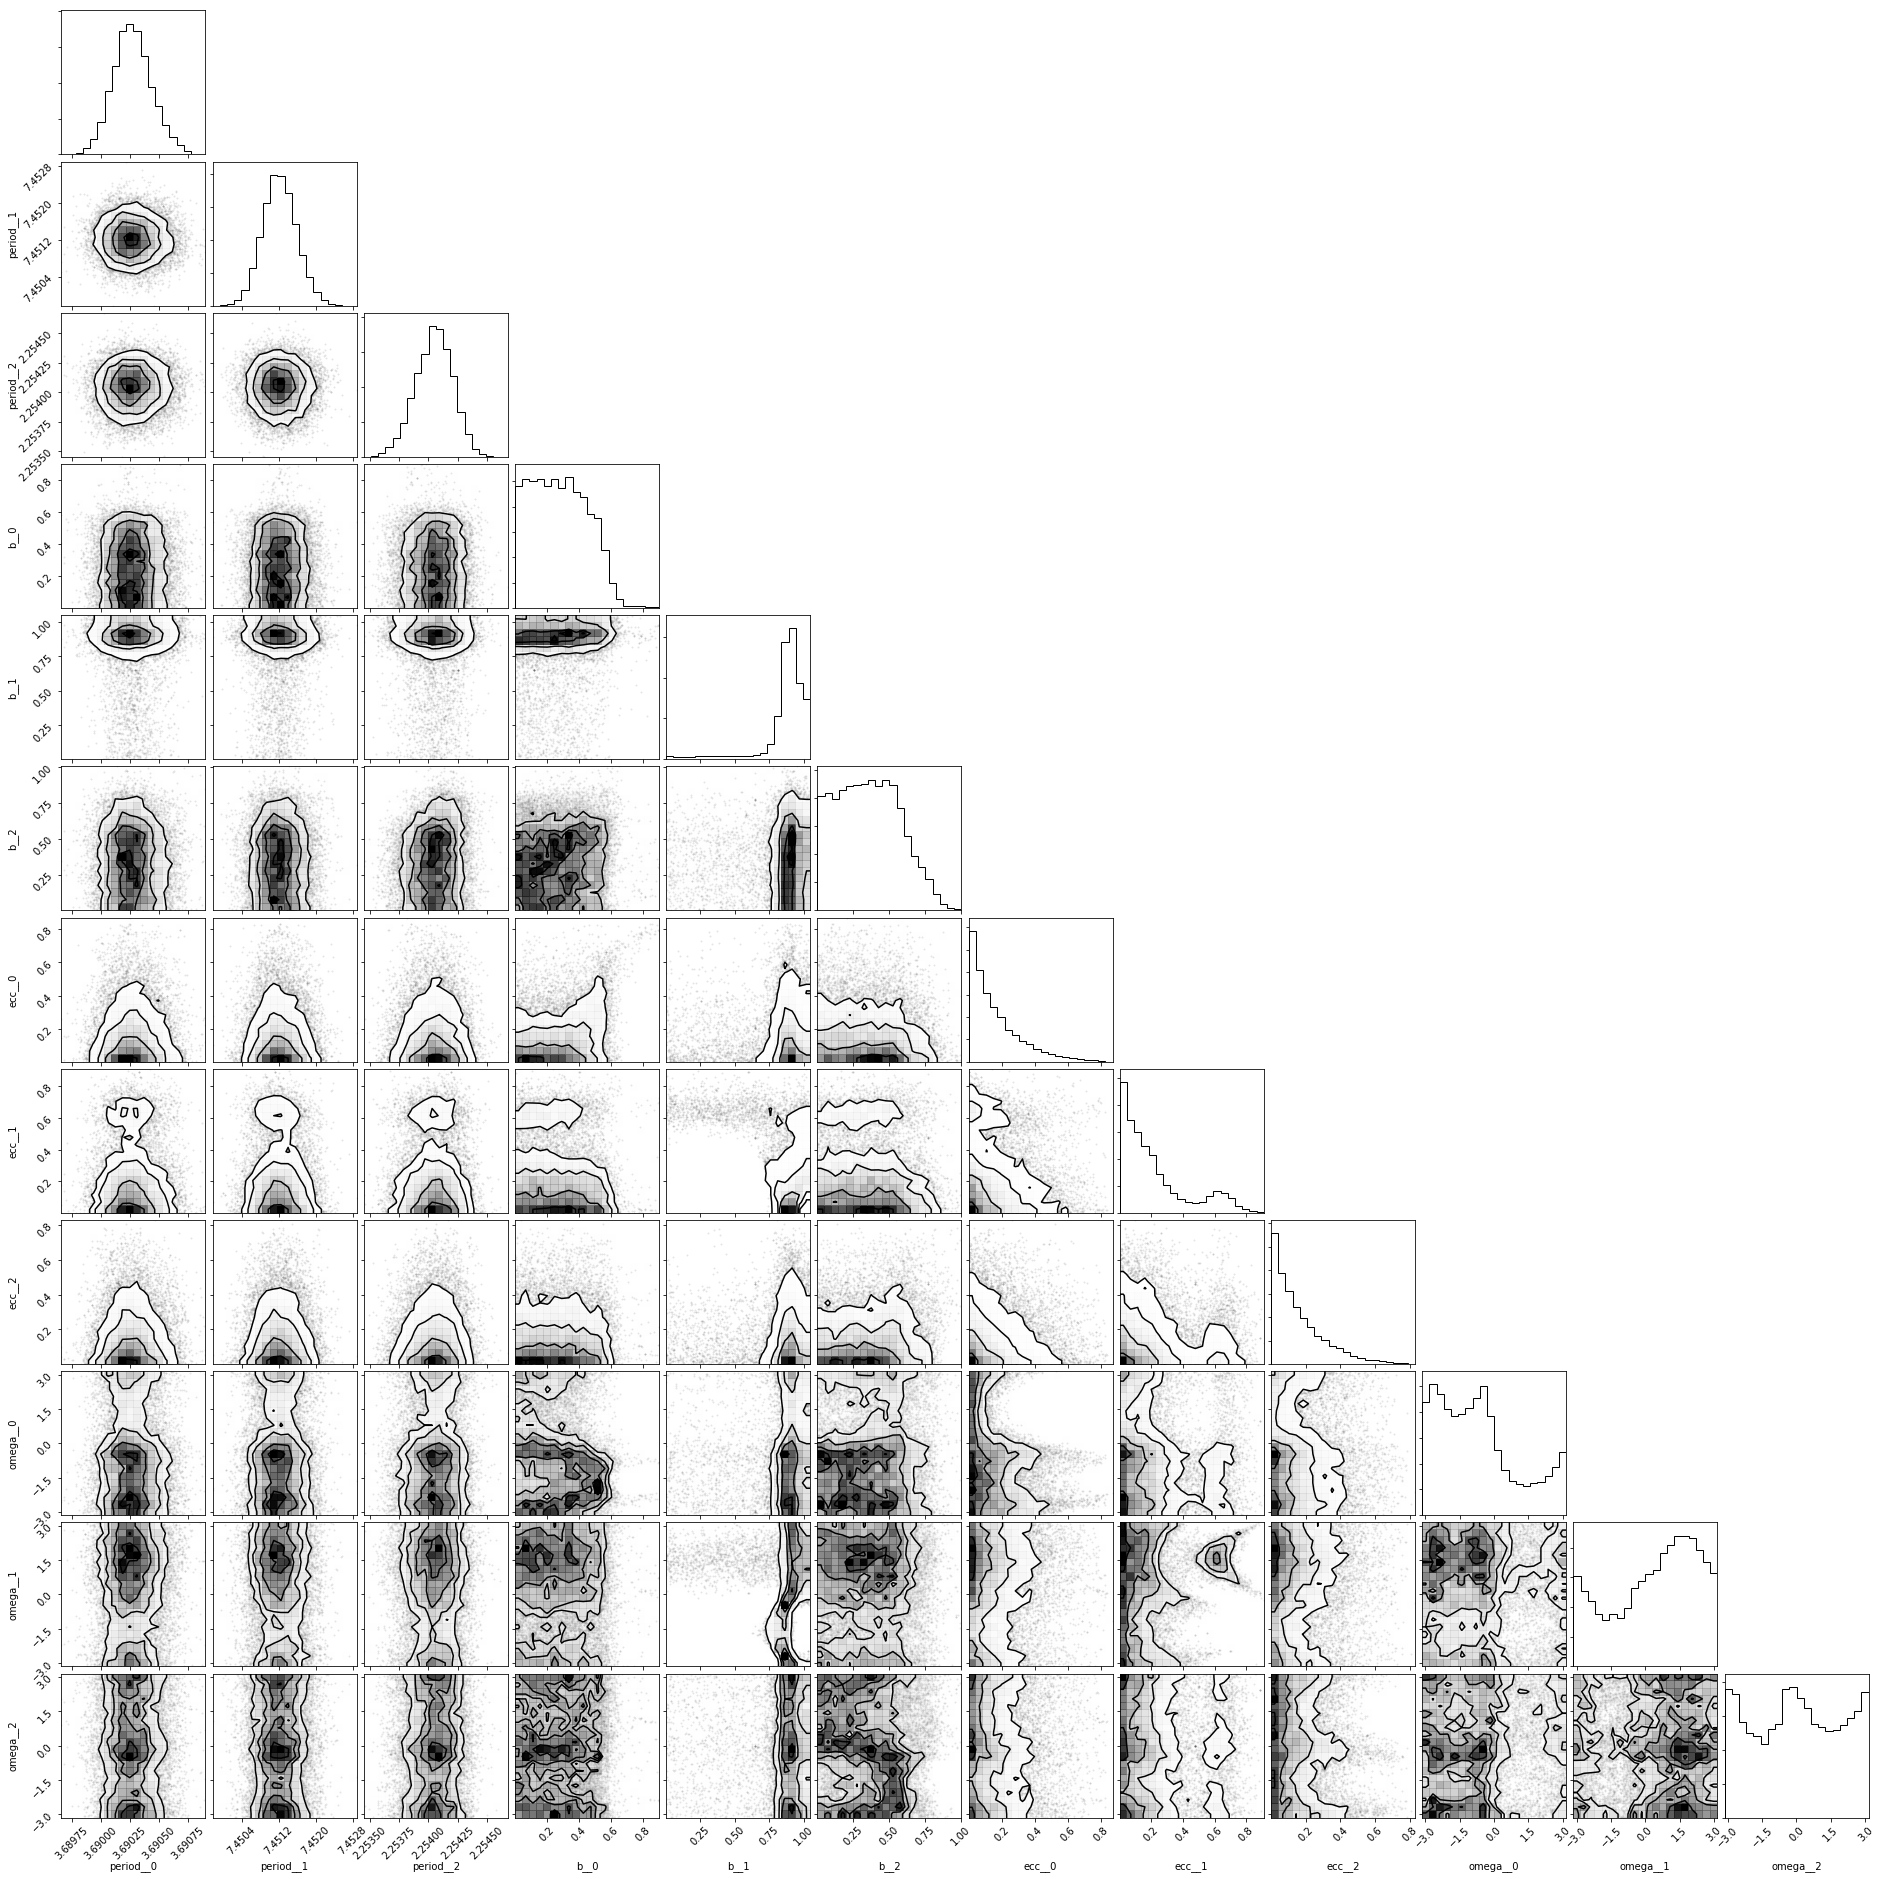

In [64]:
import corner
varnames = ["period", "b", "ecc", "omega"]
samples = pm.trace_to_dataframe(trace, varnames=varnames)
corner.corner(samples);


KeyError: 'Unknown variable light_curves'

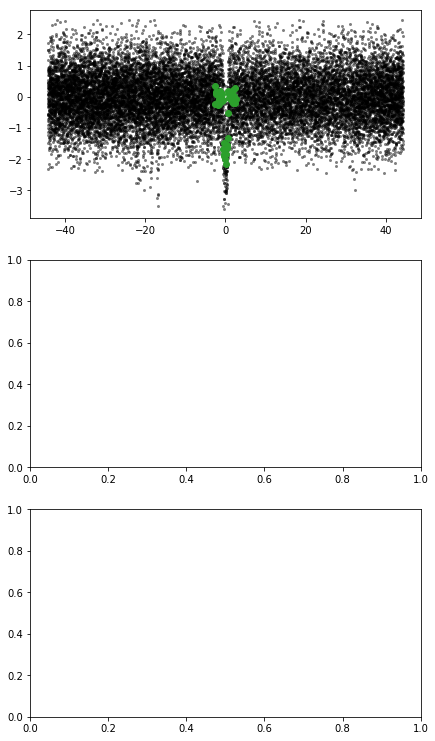

In [35]:
fig, axes = plt.subplots(3, 1, figsize=[7,13])

# Compute the GP prediction
gp_mod = np.median(trace["gp_pred"] + trace["mean"][:, None], axis=0)

for i, ax in enumerate(axes):

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:,i])
    t0 = np.median(trace["t0"][:,i])

    # Plot the folded data
    x_fold = (x[mask] - t0 + 0.5*p) % p - 0.5*p
    ax.plot(x_fold * 24., y[mask] - gp_mod, ".k", label="data",
             alpha=0.5, zorder=-1000, mec="none")

    # Overplot the phase binned light curve
    bins = np.linspace(-0.11, 0.11, 50)
    denom, _ = np.histogram(x_fold, bins)
    num, _ = np.histogram(x_fold, bins, weights=y[mask])
    denom[num == 0] = 1.0
    ax.plot(0.5*(bins[1:] + bins[:-1]) *  24., num / denom, "o", color="C2",
             label="binned")

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = trace["light_curves"][:, inds, i]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    ax.plot(x_fold[inds] * 24., pred[1], color="C1", label="model")
    art = ax1.fill_between(x_fold[inds] * 24., pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")

    # Annotate the plot with the planet's period
    txt = "period = {0:.5f} +/- {1:.5f} days".format(
        np.mean(trace["period"][:, i]), np.std(trace["period"][:, i]))
    ax.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points",
                 ha="left", va="bottom", fontsize=12)

    ax.legend(fontsize=10, loc=4)
    ax.set_xlabel("time since transit [hours]")
    ax.set_ylabel("de-trended flux")
    ax.set_xlim(-2, 2);

(<matplotlib.axes._subplots.AxesSubplot at 0x7f428e1bf0f0>,
 <matplotlib.gridspec.GridSpec at 0x7f42476561d0>)

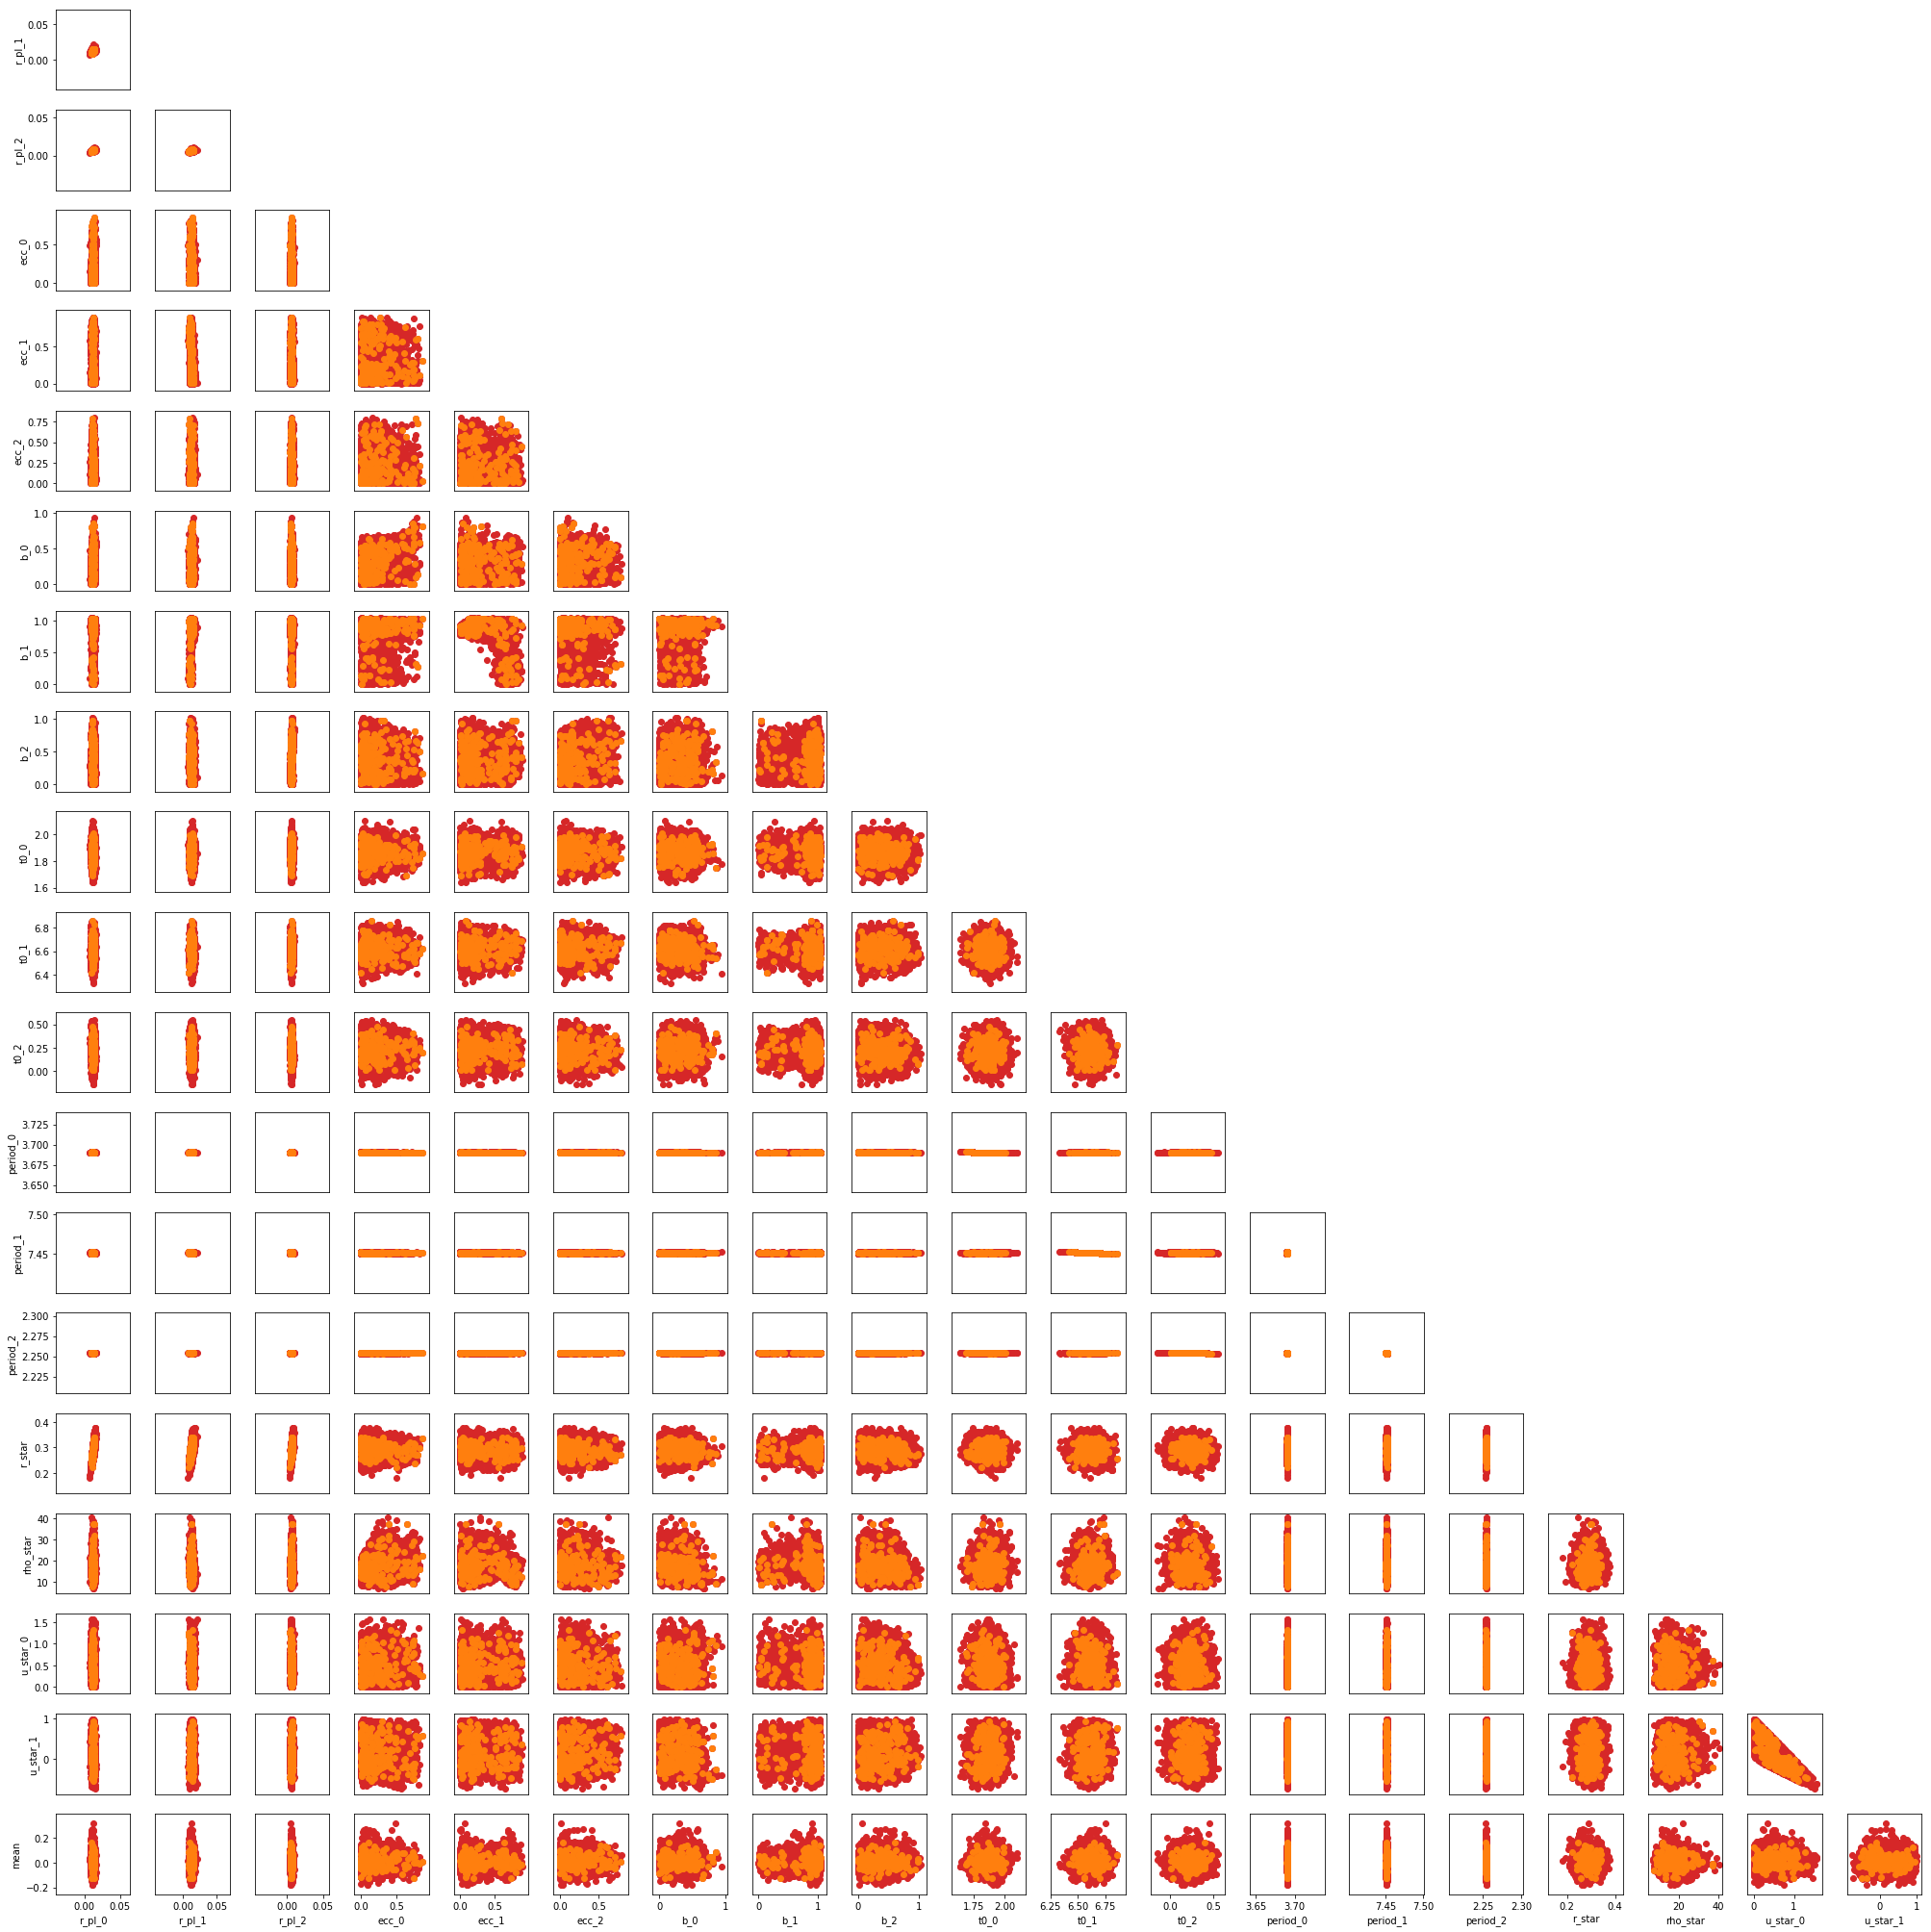

In [48]:
pm.pairplot(trace, varnames=["r_pl", "ecc", "b", "t0", "period", "r_star", "rho_star", "u_star", "mean"], color='C3',
            divergences=True,
            kwargs_divergence={'color': 'C1'})

In [45]:
trace["period"][:,i]

array([2.25248778, 2.25251354, 2.25248822, ..., 2.25287813, 2.25287939,
       2.25286491])

In [51]:
trace["light_curves"]

(4000, 18146, 3)

In [17]:
np.cos(np.degrees(0))

1.0

In [108]:
q = np.array([])
for i in np.arange(0,360,0.1):
    for j in np.arange(0,1,0.05):
        q = np.r_[q, (j**0.5*np.sin(np.radians(i)))**2 + (j**0.5*np.cos(np.radians(i)))**2]

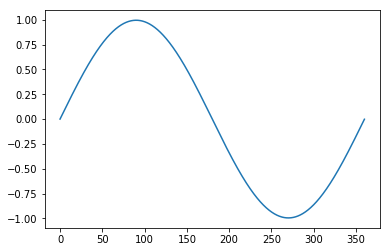

In [107]:
plt.plot(np.arange(0,360,0.1), 0.99**0.5*np.sin(np.radians(np.arange(0,360,0.1))))

In [113]:
np.min(q)

0.0

In [68]:
(-1.0*np.cos(np.degrees(i)))**2 + (-1.0*np.cos(np.degrees(i)))**2

1.2421037455052377

In [69]:
i

359.90000000000003

var

In [58]:
light_curve = pm.math.sum(light_curves, axis=-1)

In [61]:
xo.StarryLightCurve([0.1,0.2])

In [49]:
map_soln0

{'mean': array(1.0570116e-11),
 'u_star_quadlimbdark__': array([-1.09861229, -0.84729786]),
 'r_star': array(0.291),
 'logrho_star': array(2.89037176),
 'logP': array([1.30564554, 2.00835142, 0.8127912 ]),
 't0': array([1.94847219, 6.65148885, 0.13112934]),
 'logror': array([-3.19381621, -3.15474939, -3.82249455]),
 'b_param_interval__': array([-1.56044586,  1.74817121, -1.38857465]),
 'ecc_interval__': array([-4.58496748, -4.58496748, -4.58496748]),
 'omega_angle__': array([[ 2.08846277e-17, -1.47812531e-15, -6.19578937e-16],
        [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00]]),
 'logs2': array(-0.37134587),
 'logS0': array(-3.6602421),
 'logw0': array(0.53987786),
 'u_star': array([0.3, 0.2]),
 'rho_star': array(18.),
 'r': array([0.04101505, 0.04264909, 0.02187317]),
 'b_param': array([0.17358268, 0.85172199, 0.1996354 ]),
 'b': array([0.18070218, 0.88804716, 0.20400206]),
 'ecc': array([0.01, 0.01, 0.01]),
 'omega': array([1.57079633, 1.57079633, 1.57079633]),
 'period': a

In [70]:
pm.trace_to_dataframe(trace).to_csv('l98-trace.csv')

In [71]:
import pickle
with open('my_model-l98.pkl', 'wb') as buff:
    pickle.dump({'model': model, 'trace': trace}, buff)

In [4]:
import pandas as pd

In [5]:
df  = pd.read_csv('l98-trace.csv')

In [20]:
pm.summary(df, varnames=['mean', 'r_star', 'logrho_star', 'logP', 't0', 'logror', 'logs2', 'logS0', 'logw0',
       'u_star', 'rho_star', 'r', 'b', 'ecc', 'omega', 'period', 'r_ple', 'a'])

TypeError: get_values() got an unexpected keyword argument 'burn'

In [45]:
names = ['mean', 'r_star', 'logrho_star', 'logP__0', 'logP__1',
       'logP__2', 't0__0', 't0__1', 't0__2', 'logror__0', 'logror__1',
       'logror__2', 'logs2', 'logS0', 'logw0', 'u_star__0', 'u_star__1',
       'rho_star', 'r__0', 'r__1', 'r__2', 'b_param__0', 'b_param__1',
       'b_param__2', 'b__0', 'b__1', 'b__2', 'ecc__0', 'ecc__1', 'ecc__2',
       'omega__0', 'omega__1', 'omega__2', 'period__0', 'period__1',
       'period__2', 'r_pl__0', 'r_pl__1', 'r_pl__2', 'r_ple__0', 'r_ple__1',
       'r_ple__2', 'a__0', 'a__1', 'a__2']

for n in names:
    print('{0}: {1:.6g}, {2:.6g}, {3:.6g}'.format(n, *np.percentile(df[n], [16,50,84])))

mean: -0.0338512, 0.0118347, 0.0593305
r_star: 0.265872, 0.290928, 0.316412
logrho_star: 2.62896, 2.84462, 3.05314
logP__0: 1.30566, 1.3057, 1.30574
logP__1: 2.00833, 2.00838, 2.00843
logP__2: 0.812656, 0.81273, 0.812796
t0__0: 1.81427, 1.87709, 1.9347
t0__1: 6.54928, 6.61827, 6.6829
t0__2: 0.124313, 0.215078, 0.316134
logror__0: -3.23399, -3.19958, -3.16716
logror__1: -3.23591, -3.14206, -3.07405
logror__2: -3.85869, -3.79481, -3.72889
logs2: -0.426114, -0.416016, -0.405391
logS0: -3.93592, -3.51347, -2.99914
logw0: 0.331224, 0.524697, 0.707727
u_star__0: 0.141008, 0.395299, 0.700286
u_star__1: -0.162438, 0.17537, 0.540021
rho_star: 13.8594, 17.1949, 21.1817
r__0: 0.0394, 0.0407794, 0.042123
r__1: 0.0393243, 0.0431936, 0.0462335
r__2: 0.0210956, 0.0224871, 0.0240195
b_param__0: 0.0844709, 0.260653, 0.450063
b_param__1: 0.778588, 0.859005, 0.94043
b_param__2: 0.115555, 0.344616, 0.568157
b__0: 0.0878436, 0.271377, 0.468704
b__1: 0.812565, 0.89681, 0.980033
b__2: 0.117979, 0.352297, 0.5

In [38]:
df.columns[0:46]

Index(['Unnamed: 0', 'mean', 'r_star', 'logrho_star', 'logP__0', 'logP__1',
       'logP__2', 't0__0', 't0__1', 't0__2', 'logror__0', 'logror__1',
       'logror__2', 'logs2', 'logS0', 'logw0', 'u_star__0', 'u_star__1',
       'rho_star', 'r__0', 'r__1', 'r__2', 'b_param__0', 'b_param__1',
       'b_param__2', 'b__0', 'b__1', 'b__2', 'ecc__0', 'ecc__1', 'ecc__2',
       'omega__0', 'omega__1', 'omega__2', 'period__0', 'period__1',
       'period__2', 'r_pl__0', 'r_pl__1', 'r_pl__2', 'r_ple__0', 'r_ple__1',
       'r_ple__2', 'a__0', 'a__1', 'a__2'],
      dtype='object')